In [70]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
os.getcwd()

'/Users/siqisun/Documents/GitHub/CMM'

In [31]:
summary = pd.read_csv("summary.csv")
summary.head()

,dim_claim_id,dim_pa_id,dim_date_id,bin,drug,reject_code,pharmacy_claim_approved,correct_diagnosis,tried_and_failed,contraindication,pa_approved,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday
0,1,1.0,1,417380,A,75.0,0,1.0,1.0,0.0,1.0,2017-01-01,2017,1,1,1,0,0,1
1,2,NaN,1,999001,A,NaN,1,NaN,NaN,NaN,NaN,2017-01-01,2017,1,1,1,0,0,1
2,3,2.0,1,417740,A,76.0,0,1.0,0.0,0.0,1.0,2017-01-01,2017,1,1,1,0,0,1
3,4,NaN,1,999001,A,NaN,1,NaN,NaN,NaN,NaN,2017-01-01,2017,1,1,1,0,0,1
4,5,NaN,1,417740,A,NaN,1,NaN,NaN,NaN,NaN,2017-01-01,2017,1,1,1,0,0,1


In [40]:
summary.groupby(["pharmacy_claim_approved"])["pa_approved"].count() #this suggests that pharmacy_claim_approved(value 0) == pa_approved(value 1)

pharmacy_claim_approved
0    555951
1         0
Name: pa_approved, dtype: int64

# prepare clean dataset and keep possible features to predict pa approval

In [32]:
#make dummy variables for bin, drug
bin_dummies = pd.get_dummies(summary["bin"]) #[999001, 417614, 417740, 417380]
drug_dummies = pd.get_dummies(summary["drug"]) #['A', 'B', 'C']
summary = pd.concat([summary, bin_dummies, drug_dummies], axis = 1)

In [33]:
summary.head()

,dim_claim_id,dim_pa_id,dim_date_id,bin,drug,reject_code,pharmacy_claim_approved,correct_diagnosis,tried_and_failed,contraindication,...,is_weekday,is_workday,is_holiday,417380,417614,417740,999001,A,B,C
0,1,1.0,1,417380,A,75.0,0,1.0,1.0,0.0,...,0,0,1,1,0,0,0,1,0,0
1,2,NaN,1,999001,A,NaN,1,NaN,NaN,NaN,...,0,0,1,0,0,0,1,1,0,0
2,3,2.0,1,417740,A,76.0,0,1.0,0.0,0.0,...,0,0,1,0,0,1,0,1,0,0
3,4,NaN,1,999001,A,NaN,1,NaN,NaN,NaN,...,0,0,1,0,0,0,1,1,0,0
4,5,NaN,1,417740,A,NaN,1,NaN,NaN,NaN,...,0,0,1,0,0,1,0,1,0,0


In [85]:
filtered = summary.copy()
filtered = summary[["pa_approved", "calendar_day", "day_of_week", "is_weekday", "is_workday", "is_holiday", 'A', 'B', 'C', 999001, 417614, 417740, 417380, "correct_diagnosis", "tried_and_failed", "contraindication"]]
filtered.columns = [str(i) for i in filtered.columns]

In [86]:
filtered.head()

,pa_approved,calendar_day,day_of_week,is_weekday,is_workday,is_holiday,A,B,C,999001,417614,417740,417380,correct_diagnosis,tried_and_failed,contraindication
0,1.0,1,1,0,0,1,1,0,0,0,0,0,1,1.0,1.0,0.0
1,NaN,1,1,0,0,1,1,0,0,1,0,0,0,NaN,NaN,NaN
2,1.0,1,1,0,0,1,1,0,0,0,0,1,0,1.0,0.0,0.0
3,NaN,1,1,0,0,1,1,0,0,1,0,0,0,NaN,NaN,NaN
4,NaN,1,1,0,0,1,1,0,0,0,0,1,0,NaN,NaN,NaN


In [88]:
filtered = filtered.dropna(subset = ["pa_approved"])
filtered.head()

,pa_approved,calendar_day,day_of_week,is_weekday,is_workday,is_holiday,A,B,C,999001,417614,417740,417380,correct_diagnosis,tried_and_failed,contraindication
0,1.0,1,1,0,0,1,1,0,0,0,0,0,1,1.0,1.0,0.0
2,1.0,1,1,0,0,1,1,0,0,0,0,1,0,1.0,0.0,0.0
9,1.0,1,1,0,0,1,1,0,0,0,0,0,1,0.0,0.0,1.0
10,1.0,1,1,0,0,1,1,0,0,1,0,0,0,1.0,1.0,0.0
14,1.0,1,1,0,0,1,1,0,0,0,1,0,0,0.0,1.0,0.0


In [56]:
filtered["pa_approved"].value_counts() #this is an unbalanced dataset, suggest roc an unbiased approach for evaluation

1.0    408319
0.0    147632
Name: pa_approved, dtype: int64

# use random forest to get features and make predictions

In [89]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(filtered.iloc[:, 1:], filtered["pa_approved"], test_size=0.25, random_state = 42)
# Import the model we are using
# Instantiate model with 100 decision trees
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100, bootstrap = True, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [90]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Probabilities for each class    
rf_probs = rf.predict_proba(X_test)[:, 1] 

roc_value is:  0.8640659214971724


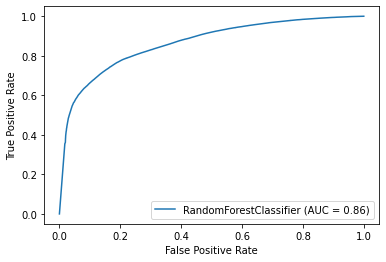

In [91]:
from sklearn.metrics import roc_auc_score    
# Calculate roc auc    
roc_value = roc_auc_score(y_test, rf_probs)  
print("roc_value is: ", roc_value)
#plot curve
from sklearn.metrics import plot_roc_curve
plot_roc_curve(rf, X_test, y_test) 
plt.show()

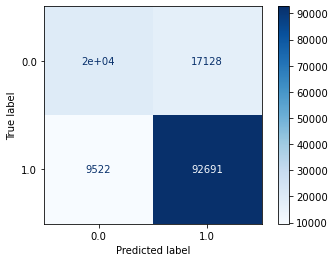

In [92]:
#plot confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rf, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

Text(0.5, 0, 'Random Forest Feature Importance')

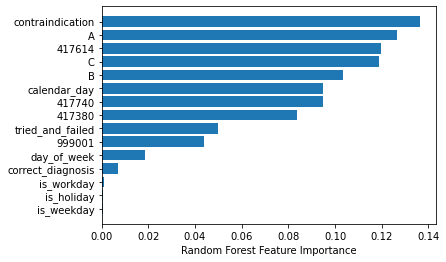

In [97]:
# Extract feature importance  
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")